# Gains (PMTs)

(author: B.Paetsch, date: 22.06.2020)

We need to take the gain of each PMT into account when looking for the PMT that gave the strongest signal for one event (important for the x-y-position reconstruction). Therefore the waveform reader was adjusted. Each adc value is now scaled by a factor that indicates the contirbution of this PMT to the total signal. The scaling factor is gained by the listed PMT gain in the XENON1T.ini file and the maximal gain (PMT 126 with 4911399 p.e./electron). 

In [15]:
import Zip
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import math

# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# for reading the ini file
from configparser import ConfigParser, ExtendedInterpolation
config = ConfigParser(inline_comment_prefixes='#', interpolation=ExtendedInterpolation(), strict=True)
config.optionsxform = str
config.read('xenon1t.ini')

# Initial parameters
baseline_ = 16382. * np.ones(n_channels)
std_ = 2.3 * np.ones(n_channels)

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

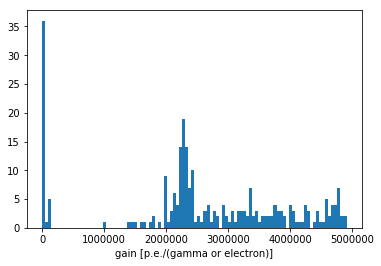

In [2]:
# plotting the gains
gain = eval(config['DEFAULT']['gains'])

plt.hist(gain, bins = 100) # bins=(100,100), range=((-100, 100),(0, 40000000)), norm=mpl.colors.LogNorm())
plt.xlabel("gain [p.e./(gamma or electron)]")
fname = 'gainsHistogram.png'
plt.savefig(fname, dpi = (200))

(4911000, 4912000)

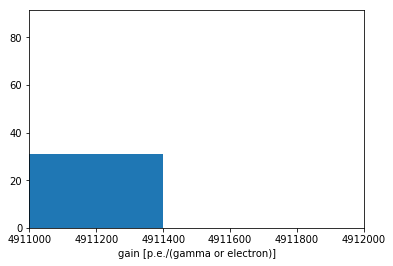

In [3]:
#maximal gain
plt.hist(gain, bins = 10) # bins=(100,100), range=((-100, 100),(0, 40000000)), norm=mpl.colors.LogNorm())
plt.xlabel("gain [p.e./(gamma or electron)]")
plt.xlim(4911000,4912000)

In [18]:
"""take gains into account for each adc value"""
"""only look at top PMTs (for position reconstruction)"""

# A waveform reader function
def Waveform(raw,eventnr,counter):
    event = raw.get_single_event(eventnr)
    ch_top = eval(config['DEFAULT']['channels_top'])
                                
    #The variables that check if a channel is the minimum channel
    adcmin = 16382
    minchannel = 0
    
    #A list that holds all the channels with significant pulses 
    channellist = []
    
    #Create the datapoint arrays
    n = 350000  
    ts = np.ones((n_channels, n), dtype=np.int16)
    ts = ts * 16382 
    t = np.linspace(0, n, n) 
    
    #Loop over all pulses in the event
    for p in event.pulses:
        ch = p.channel
        if ch in ch_top: #<128: #only top PMTs
            i = np.zeros(n_channels, dtype = int)
            #print(p.channel, ": ", p.left, p.right-p.left)
            for adc in p.raw_data:
                try:
                #Add the ADC value to the appropriate channel array
                    ts[ch][p.left + i[ch]] = adc
                    #print("adc: ", adc)
                    if gain[ch]!=0:
                        adc_corrected = 16382 - (16382 - adc)/gain[ch]*4911399 #corrected by relative gain
                        #print("%: ", gain[ch]/4800000)
                    else:
                        adc_corrected = np.inf #if we put 0 here, PMTs with 0 gain are taken into account for minchannel
                    #print("corrected: ",adc_corrected)
                    i[ch] = i[ch] + 1
                    c = 0 #for the counter
                except IndexError:
                    if c == 0:
                        counter += 1
                    pass
                #Append all significant main channels to the list
                if adc_corrected < 15000 and ch not in channellist and ch in det_ch['tpc']:
                    channellist.append(ch)
                
                #Check which channel is the minimum channel
                if adc_corrected < adcmin:
                    adcmin = adc_corrected
                    minchannel = ch
                
    #Sort for convenience
    channellist.sort()
    return t, ts, channellist, minchannel, counter

In [19]:
Waveform(NG,1,0)

(array([  0.00000000e+00,   1.00000286e+00,   2.00000571e+00, ...,
          3.49998000e+05,   3.49999000e+05,   3.50000000e+05]),
 array([[16382, 16382, 16382, ..., 16382, 16382, 16382],
        [16382, 16382, 16382, ..., 16382, 16382, 16382],
        [16382, 16382, 16382, ..., 16382, 16382, 16382],
        ..., 
        [16382, 16382, 16382, ..., 16382, 16382, 16382],
        [16382, 16382, 16382, ..., 16382, 16382, 16382],
        [16382, 16382, 16382, ..., 16382, 16382, 16382]], dtype=int16),
 [21,
  31,
  36,
  38,
  58,
  61,
  64,
  66,
  78,
  85,
  87,
  89,
  90,
  106,
  107,
  108,
  109,
  114,
  115,
  119],
 107,
 0)

In [20]:
#compare to the channellist without correction: [64, 106, 107, 108], minchannel: [107]